Starting Analysis: Reading cleaned_data.csv...
Data Loaded Successfully. Shape: (859927, 24)
Columns found: ['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url', 'url', 'license', 'full_name', 'language', 'forks', 'stars', 'decision_time_hours', 'body_word_count', 'is_merged', 'language_grouped']
-> Using 'user' as Agent column.
Filtering data...
-> Top 15 Agents: ['Copilot', 'devin-ai-integration[bot]', 'tamnd', 'ClubBoss', 'dvaitam', 'MontrealAI', 'splanck', 'WSG23', 'print3git', 'KristopherKubicki', 'adrianwedd', 'turdjali', 'joeloverbeck', 'arran4', 'Ladvien']
Generating Pivot Table...
Pivot Table generated. Plotting...
SUCCESS! Output generated: rq1_heatmap.png


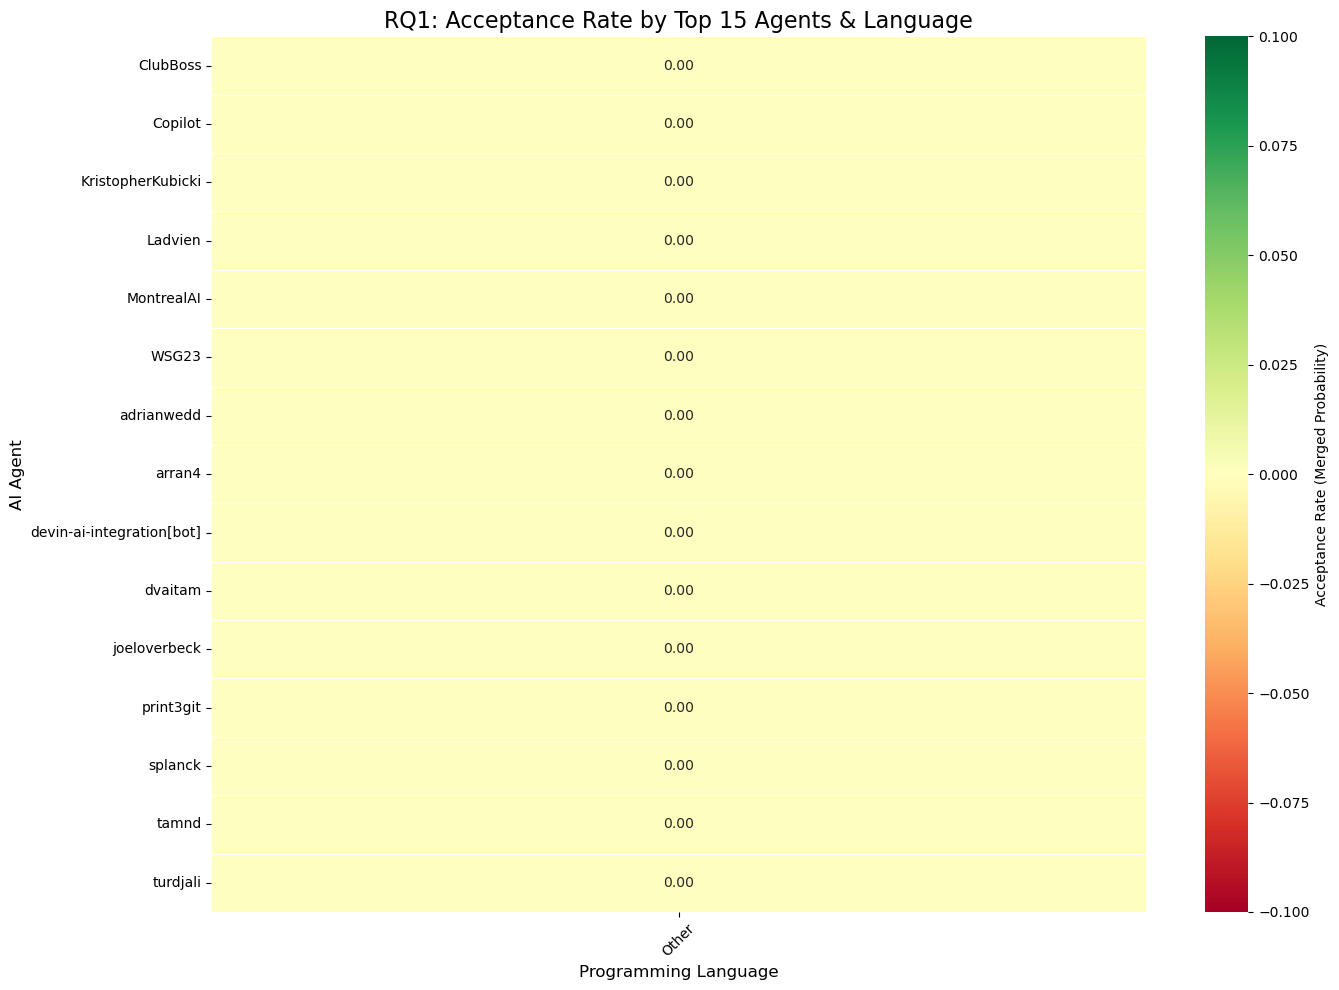

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_rq1(input_file, output_image):
    print("="*40)
    print(f"Starting Analysis: Reading {input_file}...")
    print("="*40)
    
 
    if not os.path.exists(input_file):
        print(f"ERROR: File '{input_file}' not found.")
        print("Please run cleaning.py first to generate the csv file.")
        return

    df = pd.read_csv(input_file)
    print(f"Data Loaded Successfully. Shape: {df.shape}")
    print(f"Columns found: {df.columns.tolist()}")

  
    if df.shape[0] == 0:
        print("ERROR: The dataset is empty (0 rows).")
        print("Check your cleaning.py logic or raw data.")
        return

   
    agent_col = None
    possible_names = ['agent_name', 'author', 'actor_login', 'user']
    for col in possible_names:
        if col in df.columns:
            agent_col = col
            break
    
    if not agent_col:
        print(f"ERROR: Could not find Agent Name column. Checked: {possible_names}")
        return
    print(f"-> Using '{agent_col}' as Agent column.")


    lang_col = 'language'
    if 'language_grouped' in df.columns:
        lang_col = 'language_grouped'
    elif 'language' in df.columns:
        print("-> 'language_grouped' not found. Creating it now...")
        top_langs = df['language'].value_counts().nlargest(10).index
        df['language_grouped'] = df['language'].apply(lambda x: x if x in top_langs else 'Other')
        lang_col = 'language_grouped'
    else:
        print("ERROR: No 'language' column found.")
        return


    val_col = 'is_merged'
    if 'is_merged' not in df.columns:
        if 'state' in df.columns:
            print("-> 'is_merged' not found. Creating it from 'state'...")
            df['is_merged'] = df['state'].astype(str).str.lower().apply(lambda x: 1 if 'merged' in x else 0)
        else:
            print("ERROR: No 'state' or 'is_merged' column found.")
            return

   
    print("Filtering data...")
    
    top_n = 15
    top_agents = df[agent_col].value_counts().nlargest(top_n).index
    print(f"-> Top {top_n} Agents: {list(top_agents)}")
    
    df_filtered = df[df[agent_col].isin(top_agents)].copy()

    print("Generating Pivot Table...")
    pivot_table = df_filtered.pivot_table(
        index=agent_col, 
        columns=lang_col, 
        values=val_col, 
        aggfunc='mean'
    )
    

    if pivot_table.empty:
        print("ERROR: Pivot table is empty. No overlapping data between Agents and Languages.")
        return

    print("Pivot Table generated. Plotting...")


    plt.figure(figsize=(14, 10))
    sns.heatmap(
        pivot_table, 
        annot=True, 
        fmt=".2f", 
        cmap='RdYlGn', 
        linewidths=.5,
        cbar_kws={'label': 'Acceptance Rate (Merged Probability)'}
    )
    
    plt.title(f'RQ1: Acceptance Rate by Top {top_n} Agents & Language', fontsize=16)
    plt.xlabel('Programming Language', fontsize=12)
    plt.ylabel('AI Agent', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()


    plt.savefig(output_image, dpi=300)
    print("="*40)
    print(f"SUCCESS! Output generated: {output_image}")
    print("="*40)

if __name__ == "__main__":
    
    input_csv = 'cleaned_data.csv'
    output_png = 'rq1_heatmap.png'
    
    analyze_rq1(input_csv, output_png)